# Marketing and Retail Analytics

OList is an e-commerce company that has faced some losses recently and they want to manage their inventory very well so as to reduce any unnecessary costs that they might be bearing.

In this assignment, we need to manage the inventory cost of this e-commerce company. We need to identify top products that contribute to the revenue and also use market basket analysis to analyse the purchase behaviour of individual customers to estimate with relative certainty, what items are more likely to be purchased individually or in combination with some other products.

So ultimately, we need to help OList to identify the product categories which they can get rid of without significantly impacting business.

In [ ]:
!pip install xlsxwriter

Loading the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_rows', 500)

# Data Exploration and Cleaning

# 1. Reading the data from all the datasets

In [ ]:
xls = pd.ExcelFile("Retail_dataset.xlsx")

In [ ]:
print(xls.sheet_names)

### ERD

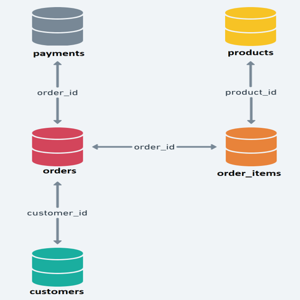

In [ ]:
# Let's first load all the excel sheets in seperate dataframes.

In [ ]:
df_data_dict = pd.read_excel(xls,sheet_name='Data Dictionary')
df_data_dict

In [ ]:
df_orders = pd.read_excel(xls,sheet_name="orders")
df_orders.head()

In [ ]:
# as we are only interested in delivered orders, we will filter out orders with order status as delivered
df_orders = df_orders[df_orders.order_status=='delivered']

In [ ]:
df_ord_items= pd.read_excel(xls,sheet_name="order_items")
df_ord_items.head()

In [ ]:
df_customers= pd.read_excel(xls,sheet_name="customers")
df_customers.head()

In [ ]:
df_payments= pd.read_excel(xls,sheet_name="payments")
df_payments.head()

In [ ]:
df_products= pd.read_excel(xls,sheet_name="products")
df_products.head()

# 2. Sanity checks and Outliers detection

### 2.1 Orders Dataframe

In [ ]:
df_orders.info()

In [ ]:
for i in df_orders.columns:
    print(f"duplicate values in {i}:", df_orders[i].duplicated().sum())

- the primary key, order_id, does not contain any duplicates

In [ ]:
# as we are only considering delivered orders, we can even drop order_status column

df_orders_cleaned = df_orders.drop('order_status',axis=1)
df_orders_cleaned.head()

In [ ]:
df_orders_cleaned.isna().sum()

In [ ]:
# let's see the null value columns

df_orders_cleaned[df_orders_cleaned.order_approved_at.isna() 
                  | df_orders_cleaned.order_delivered_timestamp.isna()].sort_values(by='order_purchase_timestamp')

- It can be observed that the missing values in 'order_approved_at' variable mostly belong to 'order_purchase_timestamp' date between 17th and 18th feb, 2017. so we can say that the missing values are dependent on 'order_purchase_timestamp' column, and can be categorised into 'Missing At Random' (MAR) category. So we will impute the missing values with the help of average time between 17th and 18th feb,2017 required to approve the order once purchased.

- Whereas the missing values from 'order_delivered_timestamp' seems to be 'missing completely at random'. So we will impute the missing values with overall average delivery time once order is approved.

In [ ]:
#  Let's find out the time required for approval after purchase order has been placed.

orders_approved_not_null = df_orders_cleaned[(df_orders_cleaned.order_purchase_timestamp>=pd.to_datetime('2017-02-17',format="%Y-%m-%d")) & (df_orders_cleaned.order_purchase_timestamp<=pd.to_datetime('2017-02-18',format="%Y-%m-%d")) & (~df_orders_cleaned.order_approved_at.isna())][['order_purchase_timestamp','order_approved_at']]
orders_approved_not_null['approval_delay']=orders_approved_not_null.order_approved_at-orders_approved_not_null.order_purchase_timestamp
orders_approved_not_null

In [ ]:
# firstly, let's check distribution of approval_delay

plt.figure(figsize=(5,3))
sns.distplot(orders_approved_not_null['approval_delay'])
plt.show()

- outliers are present, so we will use median.

In [ ]:
# imputing the missing values in order_approved_at column by calculating average time 
# required to approve the order after purchase and adding that time to purchase time.

In [ ]:
avg_approval_delay = orders_approved_not_null['approval_delay'].median()
avg_approval_delay

In [ ]:
df_orders_cleaned['order_approved_at'].fillna(df_orders_cleaned.order_purchase_timestamp+avg_approval_delay,inplace=True)

In [ ]:
# Let's handle missing values from 'order_delivered_timestamp' column.

In [ ]:
# By looking at missing values from 'order_delivered_timestamp', we could not deduce any pattern in their missingness.
# let's impute with median value of delivery time.

In [ ]:
orders_delivered_not_null = df_orders_cleaned[~df_orders_cleaned.order_delivered_timestamp.isna()][['order_purchase_timestamp','order_approved_at','order_delivered_timestamp']]
orders_delivered_not_null['delivery_time']=orders_delivered_not_null.order_delivered_timestamp-orders_delivered_not_null.order_approved_at
orders_delivered_not_null.sort_values("delivery_time")

- We are getting delivery_time as negative in some records, which means that there must be some issue with the orders approval or orders delivery timestamp.

In [ ]:
# let's check the records where order_approved_at > order_delivered_timestamp

In [ ]:
idx = orders_delivered_not_null[orders_delivered_not_null.order_delivered_timestamp<
                                orders_delivered_not_null.order_approved_at].index

df_orders_cleaned.loc[idx].sort_values(by='order_purchase_timestamp').iloc[:,2:]

In [ ]:
# df_orders_cleaned.loc[idx].sort_values(by='order_purchase_timestamp')['order_purchase_timestamp']

- In the above records, the orders have been approved after they are updated as delivered, which clearly signifies some issue in the records.
- We can rule out the possibility that in above records, delivered and approved time have been swapped with each other because in some records the delivery time after approval would become few minuts (as low as approx 5 mins), which does not seem fisible.
- If we observe carefully, the some of the orders on days like 2017-09-13,2018-04-24,2018-07-05,etc.. have been approved sequencially with very short timespan in between them. This shows that the orders were delivered without being approved and later on marked approved once delivery time has been updated.
- So, we will replace the above values from 'order_approved_at' column with avg_time required for approval after purchase.

In [ ]:
df_approval_time = df_orders_cleaned[~df_orders_cleaned.index.isin(idx)][['order_purchase_timestamp','order_approved_at']]
df_approval_time['approval_time'] = df_approval_time.order_approved_at-df_approval_time.order_purchase_timestamp
df_approval_time.sort_values('approval_time')

In [ ]:
# checking distribution of approval_time

plt.figure(figsize=(5,3))
sns.distplot(df_approval_time.approval_time)
plt.show()

- we will use median because of outliers

In [ ]:
avg_approval_time = df_approval_time.approval_time.median()
avg_approval_time

In [ ]:
# let's correct the records in 'order_approved_at' column which were updated after delivery. 

df_orders_cleaned.loc[idx,'order_approved_at'] = df_orders_cleaned.order_purchase_timestamp + avg_approval_time

In [ ]:
# Now the records have been cleaned, Let's find out average order_delivered_timestamp.

In [ ]:
orders_delivered_not_null = df_orders_cleaned[~df_orders_cleaned.order_delivered_timestamp.isna()][['order_approved_at','order_delivered_timestamp']]
orders_delivered_not_null['delivery_time'] = orders_delivered_not_null.order_delivered_timestamp-orders_delivered_not_null.order_approved_at
orders_delivered_not_null.sort_values('delivery_time')

In [ ]:
# Checking distribution of 'delivery_time'

plt.figure(figsize=(5,3))
sns.distplot(orders_delivered_not_null['delivery_time'])
plt.show()

- Now, the delivery time distribution is correct and we will use median to impute the missing values

In [ ]:
avg_delivery_time = orders_delivered_not_null['delivery_time'].median()
avg_delivery_time

In [ ]:
df_orders_cleaned['order_delivered_timestamp'].fillna(df_orders_cleaned.order_approved_at+avg_delivery_time,inplace=True)

In [ ]:
df_orders_cleaned.reset_index(drop=True,inplace=True)

In [ ]:
df_orders_cleaned.head()

In [ ]:
# let's create a new variable 'Month-Year' from simple visualisation perspective

df_orders_cleaned['order_yr_mon'] = df_orders_cleaned.order_purchase_timestamp.apply(lambda x:pd.to_datetime(str(x.month)+"-"+str(x.year),format='%m-%Y'))

In [ ]:
# let's create a new variable to identify whether the order was delayed or not?

df_orders_cleaned['is_order_delayed'] = df_orders_cleaned.apply(lambda x:"Delayed" 
                                                                if x['order_estimated_delivery_date']<x['order_delivered_timestamp']
                                                                else "Not Delayed",axis=1)

In [ ]:
df_orders_cleaned.head()

In [ ]:
# finally, lets convert object data to categorical data

for col in df_orders_cleaned.select_dtypes("object").columns:
    df_orders_cleaned[col] = df_orders_cleaned[col].astype("category")

In [ ]:
df_orders_cleaned.info()

### 2.2 Ordered Items Dataframe

In [ ]:
df_ord_items.info()

In [ ]:
# here, we do not have any information of sellers other than their ids, which is not of much use, so let's drop that column.

df_ord_items.drop('seller_id',axis=1,inplace=True)

In [ ]:
# let's check for duplicate values by consideing 'order_id','order_item_id' as composite primary key.

df_ord_items.set_index(['order_id','order_item_id']).index.duplicated().sum()

In [ ]:
df_ord_items[['price','shipping_charges']].describe()

We can definitely observe outliers, we will look into it on later stage

In [ ]:
# lets check the order_item_id column for any anomaly. 

df_ord_items['order_item_id'].value_counts()

In [ ]:
# We can convert order_item_id variable along with object variables to categorical variable.

In [ ]:
for col in ['order_id', 'product_id']:
    df_ord_items[col] = df_ord_items[col].astype("category")

In [ ]:
df_ord_items.info()

### 2.3 Customers Dataframe

In [ ]:
df_customers.info()

In [ ]:
df_customers.shape

In [ ]:
# let's check for duplicate values
for i in df_customers.columns:
    print(f"duplicate values in {i}:", df_customers[i].duplicated().sum())

- The customer_id is primary key for this dataset and it contains 3345 duplicate values.

In [ ]:
# let's drop these duplicate values 

df_customers_cleaned = df_customers.drop_duplicates(subset=['customer_id'], keep='first')

In [ ]:
df_customers_cleaned = df_customers_cleaned.reset_index(drop=True)
df_customers_cleaned

In [ ]:
# Finally, lets convert all the object columns to categorical along with zip_code column
for col in df_customers_cleaned.columns:
    df_customers_cleaned[col] = df_customers_cleaned[col].astype('category')

In [ ]:
df_customers_cleaned.info()

### 2.4 Payments Dataframe

In [ ]:
df_payments.info()

In [ ]:
# let's check for duplicate values
for i in df_payments.columns:
    print(f"duplicate values in {i}:", df_payments[i].duplicated().sum())

- The order_id contains some duplicate values but its acceptable, as for one order there can be multiple sequence of payments which can lead to duplicate order_id.

In [ ]:
#  let's check if 'order_id','payment_sequential' together gives us any duplicate values
df_payments.set_index(['order_id','payment_sequential']).index.duplicated().sum()

In [ ]:
for i in ['payment_sequential','payment_installments','payment_type']:
    print(df_payments[i].value_counts(),end="\n\n")

In [ ]:
#  let's check the payment_type variable as it is the only categorical variable with some null values

In [ ]:
df_payments[df_payments.payment_type=='not_defined']

In [ ]:
# the payment_value corresponding to payment_type not_defined is 0, let's check the same for all the 
# records having 0 payment_value

In [ ]:
df_payments[df_payments.payment_value==0]

In [ ]:
# where ever payment_value is 0, the payment_type is voucher, so let's impute the null values with 'voucher'.

In [ ]:
df_payments.loc[df_payments.payment_type=='not_defined','payment_type'] = 'voucher'

In [ ]:
# Let's convert the variables to categorical data type

for col in ['order_id', 'payment_type',]:
    df_payments[col] = df_payments[col].astype("category")

### 2.5 Products dataframe

In [ ]:
df_products.describe()

In [ ]:
df_products.info()

- null values are present in all the variables apart from product_id

In [ ]:
# let's check for duplicate values

for i in df_products.columns:
    print(f"duplicate values in {i}:", df_products[i].duplicated().sum())

- The primary key product_id does not have any duplicate values.

In [ ]:
# let's check the null value count

df_products.isna().sum()

In [ ]:
# let's first check for product weight variable
df_products[df_products.product_weight_g.isna()]

- It is evident that for the above product_id all the information related to product specification is missing. and the missingness is completely at random, we will impute them with median values because of presence of outliers.

In [ ]:
# imputing null values with median
for col in ['product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm']:
    df_products[col].fillna(df_products[col].median(),inplace=True)

In [ ]:
# let's check missing value percentage from product_category_name
df_products.product_category_name.value_counts(normalize=True,dropna=False)*100

- 75% of products belong to 'Toys' category and 0.5% are null values. let's impute null values with mode. 

In [ ]:
mode = df_products.product_category_name.mode()[0]
mode

In [ ]:
# filling null values with mode
df_products.product_category_name.fillna(mode,inplace=True)

In [ ]:
# changing object data type to categorical

for col in ['product_id','product_category_name']:
    df_products[col] = df_products[col].astype('category')

In [ ]:
df_products.info()

# 3. Univariate Analysis and Detection of Outliers


- Our aim is to 
1) Understand the distribution of numerical and categorical data. 
2) Check for presence of outliers in numerical data.

### 3.1 Orderes data

In [ ]:
df_orders_cleaned.head()

In [ ]:
df_orders_cleaned.info()

In [ ]:
# count of delayed vs not delayed orders

df_orders_cleaned.groupby("is_order_delayed")['order_id'].count().plot.bar()
plt.show()

- majority of orders were delivered on or before time.

In [ ]:
# most delayed order month-year

df_orders_cleaned[df_orders_cleaned.is_order_delayed=="Delayed"].groupby('order_yr_mon')['order_id'].count().sort_index().plot()
plt.show()

- The number of orders delayed were highest in '03-2018' followed by '02-2018'

### 3.2 Ordered Items data

In [ ]:
df_ord_items.head()

In [ ]:
df_ord_items.describe(percentiles=[0.25,0.50,0.75,0.90,0.95,0.99])

- the difference between 99th percentile and max value in 'price' and 'shipping_charges' is quite large, which signifies presence of outliers. we will check the distribution and take decision accordingly.

In [ ]:
plt.figure(figsize=(15,5))
for i,j in enumerate(['price','shipping_charges']):
    plt.subplot(1,2,i+1)
    sns.boxplot(df_ord_items[j])
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
for i,j in enumerate(['price','shipping_charges']):
    plt.subplot(2,1,i+1)
    sns.distplot(df_ord_items[j])
    plt.axvline(df_ord_items[j].mean(), color="red")
    plt.axvline(df_ord_items[j].median(), color="green")
    plt.xlabel(None)
    print(f"skewness in {j} distribution:", round(df_ord_items[j].skew(),2))
    plt.title(j)
plt.show()

- all of the distributions are positively skewed, which denotes that the outliers are present towards the right of the distribution

In [ ]:
plt.figure(figsize=(10,5))
df_ord_items.order_item_id.value_counts().plot.bar()
plt.show()

- Majority of orders consists of item_no 1. We can sday that item_no 1 is the most popular product.

### 3.3 Products data

In [ ]:
df_products.head()

In [ ]:
df_products.describe(percentiles=[0.25,0.50,0.75,0.90,0.95,0.99])

In [ ]:
#  top 20 product categories
plt.figure(figsize=(10,5))
(df_products.product_category_name.value_counts()[:20]).plot.bar()
plt.title("product_category_name count")
plt.show()

- Toys are the most popular product category

In [ ]:
prod_num_cols = df_products.select_dtypes('float64').columns
prod_num_cols

In [ ]:
plt.figure(figsize=(15,10))
for i,j in enumerate(prod_num_cols,1):
    plt.subplot(2,2,i)
    sns.boxplot(df_products[j])
    plt.title(j)
plt.show()

- In all the variables, outliers are present

In [ ]:
plt.figure(figsize=(15,8))
for i,j in enumerate(prod_num_cols,1):
    plt.subplot(2,2,i)
    sns.distplot(df_products[j])
    plt.axvline(df_products[j].mean(),color='red')
    plt.axvline(df_products[j].median(),color='green')
    print(f"skewness in {j} distribution:", round(df_products[j].skew(),2))
    plt.xlabel(None)
    plt.title(j)
plt.show()

- all of the distributions are positively skewed, which denotes that the outliers are present towards the right of the distribution

### 3.4 Payments data

In [ ]:
df_payments.head()

In [ ]:
df_payments.describe()

In [ ]:
# although the payment_sequencials and payment_installments column is numerical, it has values from 1 to 29 and 0 to 24 respectively
# and it can be considered as categorical column, lets check the value count 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df_payments['payment_sequential'].value_counts().sort_index().plot.bar()
plt.title('payment_sequential')
plt.subplot(1,2,2)
df_payments['payment_installments'].value_counts().sort_index().plot.bar()
plt.title('payment_installments')
plt.show()

- Majority of orders were paid in single transaction only, i.e. only through 1 mode or source of payment.
- Majority of orders were paid in 1 installment. Also, we can observe a declining trend in the number of orders as the number of installments increases, with exception at 8 and 10 installments

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.boxplot(df_payments['payment_value'])
plt.title('payment_value distribution')
plt.subplot(2,1,2)
sns.distplot(df_payments['payment_value'])
plt.axvline(df_payments['payment_value'].mean(),color='red')
plt.axvline(df_payments['payment_value'].median(),color='green')
plt.title('payment_value distribution')
plt.show()

- Outliers are present in the payments_value variable

### 3.5 Customer data

In [ ]:
df_customers_cleaned.head()

In [ ]:
df_customers_cleaned.info()

In [ ]:
# only checking top 20 cities based on count
plt.figure(figsize=(10,5))
((df_customers_cleaned.customer_city.value_counts()*100)[:20]).plot.bar()
plt.title("Top 20 cities")
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
df_customers_cleaned.customer_state.value_counts().plot.bar()
plt.title("Statewise count of customers")
plt.show()

- SP has highest number of customers
- RR has lowest number of customers

# 4. Bivariate and Multivariate Analysis

### 4.1 Order Items Data

In [ ]:
# barplot function
def bar_plot(df,x,y,estimator='mean'):
    plt.figure(figsize=(10,5))
    sns.barplot(data=df,x=x,y=y,estimator=estimator)
    plt.title(x+" Vs "+y)
    plt.show()

In [ ]:
df_ord_items.head()

In [ ]:
plt.figure(figsize=(15,5))
sns.regplot(data=df_ord_items,x='price',y='shipping_charges',marker='x')
plt.show()

- price and shipping charges are roughly showing positive correlation but it is quite weak.

### 4.2 Products data

In [ ]:
num_cols = ['product_weight_g','product_length_cm','product_height_cm','product_width_cm']

In [ ]:
for i in num_cols:
    plt.figure(figsize=(15,5))
    df_products.groupby(by='product_category_name')[i].median().sort_values(ascending=False).plot.bar()
    plt.title('product_category_name Vs '+i)
    plt.show()

Product_category with highest
- product_weight_g - Office_furniture
- product_length_cm - Office_furniture
- product_height_cm - Office_furniture
- product_width_cm - computers

In [ ]:
sns.heatmap(df_products[num_cols].corr(),cmap="RdYlGn",annot=True)
plt.show()

some variables are showing moderate correlation, although not strong but they are linearly dependent 
- product_weight and product_height
- product_length and product_width
- product_weight and product_width

### 4.3 payments data

In [ ]:
df_payments.head()

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_payments,x='payment_type',y='payment_value')
plt.title('payment_type VS payment_value')
plt.show()

- Beacause of outliers, it is difficult to interprete but if we compare max values then we can say that customers prefer credit_card for higher payment values and voucher for lower payment_value.

In [ ]:
bar_plot(df=df_payments,x='payment_type',y='payment_value',estimator='median')

- it is evident that credit_card is generally used for transactions above $100. 

In [ ]:
bar_plot(df=df_payments,x='payment_installments',y='payment_value',estimator='median')

- It is evident that as the payment_value increases, customers tend to opt for higher number of installments.

In [ ]:
bar_plot(df=df_payments,x='payment_sequential',y='payment_value',estimator='median')

- As we have already seen that majority of orders were paid through single payment mode only, but we can observe a declining trend in payment value as the sequence of payment increases.
- The major amount of payment_value is paid on the 1st payment of sequencial payments.

# 5. Merged Data

In [ ]:
df_retail = df_ord_items.merge(df_products,how='inner',on='product_id')
df_retail = df_retail.merge(df_orders_cleaned,how='inner',on='order_id')
df_retail = df_retail.merge(df_payments,how='inner',on='order_id')
df_retail = df_retail.merge(df_customers_cleaned,how='inner',on='customer_id')
df_retail

In [ ]:
df_retail.isna().sum()

In [ ]:
df_retail.shape

In [ ]:
df_retail.info()

In [ ]:
# The datatype of columns, basis on which we performed merge, have been changed to object, let's change it back to category.
for col in df_retail.select_dtypes('object').columns:
    df_retail[col] = df_retail[col].astype('category')

In [ ]:
df_retail.describe(percentiles=[0.25,0.50,0.75,0.90,0.95,0.99])

# 6. Bivariate and Multivariate analysis on merged data

In [ ]:
numerical_cols = df_retail.select_dtypes('float64').columns
numerical_cols

In [ ]:
# after merging the data sets, the outliers might have changed, let's check with box plot

plt.figure(figsize=(15,15))
for i,j in enumerate(numerical_cols,1):
    plt.subplot(4,2,i)
    sns.boxplot(df_retail[j])
    plt.title(j)
plt.show()

- The numerical data contains outliers, although extreme they are all valid values so removing them will lead to misinterpretation of results.

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(df_retail[numerical_cols].corr(),cmap="RdYlGn",annot=True)
plt.show()

Based on the correlation coefficient, we can say that
- price and payment_value are strongly correlated.
- product_weight_g and shipping_charges show moderate correlation.

Let's also check pair plots to see if we can find any pattern among these variables

In [ ]:
sns.pairplot(df_retail[numerical_cols])
plt.show()

- Apart from the already deduced correlations, majority of the other variables are randomly distributed.

In [ ]:
# customer_state

plt.figure(figsize=(15,15))
for i,j in enumerate(['price','payment_value','shipping_charges'],1):
    plt.subplot(3,1,i)
    df_retail.groupby(by='customer_state')[j].median().sort_values(ascending=False).plot.bar()
    plt.title('customer_state Vs. '+j)
    plt.xlabel(None)
plt.show()

- 'AC' state has highest median 'payment_value' where as 'SP' has the lowest value for all 3 variables.

In [ ]:
(df_retail[df_retail.is_order_delayed=="Delayed"]).groupby(by='customer_state')['customer_state'].count().sort_values(ascending=False).plot.bar()
plt.show()

- Highest delayed orders were from state 'SP' which happens to have lowest median order price and lowest median shipping_charges. 
- There could be some interesting relationship between shipping_charges and order being delayed.

In [ ]:
df_retail.groupby(by='customer_state')['shipping_charges'].median().sort_values(ascending=False).plot.bar()
plt.ylabel("shipping_charges_(median) ")
ax2 = plt.twinx()
(df_retail[df_retail.is_order_delayed=="Delayed"]).groupby(by='customer_state')['customer_state'].count().plot(ax=ax2,color="red",ylabel="Count of delayed orders")
plt.show()

#### 'Delayed_orders'
- we can roughly say that the order getting delayed is dependent on the amount of shipping_chareges paid, higher the shipping_charges lower is the possibility of delay.

# 7. Saving the cleaned Dataset

In [ ]:
df_retail.to_csv('retail_dataset_cleaned.csv')

# 8. Data Preparation for Market Basket Analysis

#### As we need to perform market basket analysis on the product category, we will only consider order_id and product category columns
#### Also we will need two different tables to perform self join in tableau.


In [ ]:
basket = df_retail[['order_id','product_category_name']]
basket.head()

#### we will also make a sr.no column for each category to uniquely identify the categories once self join is performed in Tableau.

In [ ]:
categories_list = df_retail.product_category_name.unique().sort_values().tolist()

In [ ]:
df_category_id = pd.DataFrame({'Category_id':range(1,len(categories_list)+1),'Category':categories_list})
df_category_id.head()

In [ ]:
df_basket = basket.merge(df_category_id,how='inner',left_on='product_category_name',right_on='Category')
df_basket.drop('Category',axis=1,inplace=True)
df_basket.head()

In [ ]:
xls = pd.ExcelWriter('Basket_data.xlsx', engine='xlsxwriter')

df_basket.to_excel(xls, sheet_name='ord_prod_1', index = False)
df_basket.to_excel(xls, sheet_name='ord_prod_2', index = False)

xls.save()